<a href="https://colab.research.google.com/github/Nicholasyxx/UCLA-Trustworth-AI-Lab-Project/blob/main/TestSDmetrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install sdmetrics

In [ ]:
import pandas as pd

real_data = pd.read_csv('census1000.csv')
synthetic_data = pd.read_csv('census1000_CTGAN_CTGAN_300_1_synthetic.csv')

In [ ]:
# BoundaryAdherence

from sdmetrics.single_column import BoundaryAdherence

BoundaryAdherence.compute(
    real_data['age'],
    synthetic_data['fnlwgt']
)

0.0

In [ ]:
# RangeCoverage

from sdmetrics.single_column import RangeCoverage

RangeCoverage.compute(
    real_data['age'],
    synthetic_data['fnlwgt']
)

1

In [ ]:
# CategoryCoverage：This metric measures whether a synthetic column covers all the possible categories that are present in a real column.

from sdmetrics.single_column import CategoryCoverage

CategoryCoverage.compute(
    real_data['workclass'],
    synthetic_data['workclass']
)

1.0

In [ ]:
# TVComplement： This metric computes the similarity of a real column vs. a synthetic column in terms of the column shapes
#                -- aka the marginal distribution or 1D histogram of the column.

from sdmetrics.single_column import TVComplement

TVComplement.compute(
    real_data['workclass'],
    synthetic_data['workclass']
)

0.9408178178178178

In [ ]:
# CategoricalCAP: How does it work? We assume that the attacker is in possession of few columns of the real data (key_fields), as well as
#                 the full synthetic dataset, including synthetic sensitive values
#                 The attacker's goal is to correctly guess the real value of the sensitive information, sensitive_fields



from sdmetrics.single_table import CategoricalCAP

# Define the key fields and sensitive fields
key_fields = ['age', 'relationship', 'sex','marital-status','education','native-country', 'occupation']
sensitive_fields = ['workclass']

CategoricalCAP.compute(
    real_data=real_data,
    synthetic_data=synthetic_data,
    key_fields=key_fields,
    sensitive_fields=sensitive_fields
)


0.4483783783783786

In [ ]:
# CardinalityShapeSimilarity： In a multi table setup, there is a parent and child table. The parent contains a primary key that uniquely identifies every row while the child contains a foreign key that refers to a parent row. The foreign keys may repeat, as multiple children can reference the same parent.、
# Requires at least two forms that are clearly related

In [ ]:
# ContingencySimilarity： This metric computes the similarity of a pair of categorical columns between the real and synthetic datasets -- aka it compares 2D distributions.

from sdmetrics.column_pairs import ContingencySimilarity

# Compute the ContingencySimilarity score
ContingencySimilarity.compute(
    real_data[['education', 'education-status']],
    synthetic_data[['education', 'marital-status']]
)

ValueError: ignored

In [ ]:
# CorrelationSimilarity: This metric measures the correlation between a pair of numerical columns and computes the similarity between the real and synthetic data -- aka it compares the trends of 2D distributions. This metric supports both the Pearson and Spearman's rank coefficients to measure correlation.

from sdmetrics.column_pairs import CorrelationSimilarity

CorrelationSimilarity.compute(
    real_data[['age', 'fnlwgt']],
    synthetic_data[['age', 'fnlwgt']],
    coefficient='Pearson' # Spearman
)

0.93072366029555

In [ ]:
# MissingValueSimilarity: This metric compares whether the synthetic data has the same proportion of missing values as the real data for a given column
# E.g., if NA/total are the same value
from sdmetrics.single_column import MissingValueSimilarity

MissingValueSimilarity.compute(
    real_data['sex'],
    synthetic_data['fnlwgt']
)

1.0

In [ ]:
# StatisticSimilarity: This metric measures the similarity between a real column and a synthetic column by comparing a summary statistic. Supported summary statistics are: mean, median and standard deviation.

from sdmetrics.single_column import StatisticSimilarity

StatisticSimilarity.compute(
    real_data['age'],
    synthetic_data['age'],
    statistic='mean' #(default) 'mean' 'median', 'std'

)

0.9498349308212322

In [ ]:
# NewRowSynthesis This metric measures whether each row in the synthetic data is novel, or whether it exactly matches an original row in the real data.
# No primary key
from sdmetrics.single_table import NewRowSynthesis

single_table_metadata_dict = {
    "primary_key": "age",
    "columns": {
        "age": {"type": "numerical"},
        "workclass": {"type": "categorical"},
        "fnlwgt": {"type": "numerical"},
        "education": {"type": "categorical"},
        "education-num": {"type": "numerical"},
        "marital-status": {"type": "categorical"},
        "occupation": {"type": "categorical"},
        "relationship": {"type": "categorical"},
        "race": {"type": "categorical"},
        "sex": {"type": "categorical"},
        "capital-gain": {"type": "numerical"},
        "capital-loss": {"type": "numerical"},
        "hours-per-week": {"type": "numerical"},
        "native-country": {"type": "categorical"},
        "income": {"type": "categorical"}
    }
}


NewRowSynthesis.compute(
    real_data,
    synthetic_data,
    metadata=single_table_metadata_dict,
    numerical_match_tolerance=0.01,
    synthetic_sample_size=10_000
)

/usr/local/lib/python3.10/dist-packages/sdmetrics/single_table/new_row_synthesis.py:68: UserWarning: The provided `synthetic_sample_size` of 10000 is larger than the number of synthetic data rows (1000). Proceeding without sampling.
  warnings.warn(f'The provided `synthetic_sample_size` of {synthetic_sample_size} '


ValueError: ignored

In [ ]:
import pandas as pd
from collections import defaultdict
from sdmetrics.single_column import CategoryCoverage, TVComplement, MissingValueSimilarity, BoundaryAdherence, RangeCoverage, StatisticSimilarity, KSComplement

def evaluate_data_quality(real_data_filename, synthetic_data_filename, attributes):
    real_data = pd.read_csv(real_data_filename)
    synthetic_data = pd.read_csv(synthetic_data_filename)

    categorical_metrics = [
        ("CategoryCoverage", CategoryCoverage.compute),
        ("TVComplement", TVComplement.compute),
        ("MissingValueSimilarity", MissingValueSimilarity.compute)
    ]

    numerical_metrics = [
        ("MissingValueSimilarity", MissingValueSimilarity.compute, {}),
        ("BoundaryAdherence", BoundaryAdherence.compute, {}),
        ("RangeCoverage", RangeCoverage.compute, {}),
        ("KSComplement", KSComplement.compute, {}),
        ("StatisticSimilarity", StatisticSimilarity.compute, {'statistic': 'mean'})
    ]



    results = defaultdict(dict)



    for attribute in attributes:
        unique_values = real_data[attribute].nunique()
        if unique_values < 10 or real_data[attribute].dtype == "object":
            data_type = "categorical"
            metrics = categorical_metrics
        else:
            data_type = "numerical"
            metrics = numerical_metrics

        for metric_name, metric_function, *optional_args in metrics:
            metric_args = optional_args[0] if optional_args else {}
            value = metric_function(real_data[attribute], synthetic_data[attribute], **metric_args)
            results[attribute][metric_name] = value

    results_df = pd.DataFrame(results).T



    final_results = {}


    for attribute, metrics in results.items():
        if "CategoryCoverage" in metrics:
            final_results[attribute] = {
                "column_coverage": metrics["CategoryCoverage"],
                "column_shape": metrics["TVComplement"],
                "MissingValueSimilarity": metrics["MissingValueSimilarity"]
            }
        else:
            final_results[attribute] = {
                "column_coverage": (metrics["BoundaryAdherence"] + metrics["RangeCoverage"]) / 2,
                "column_shape": metrics["KSComplement"],
                "MissingValueSimilarity": metrics["MissingValueSimilarity"]
            }

    final_df = pd.DataFrame(final_results).T

    return final_df





attributes = ['workclass','education', 'marital-status', 'occupation', 'relationship', 'race', 'native-country', 'sex',
              'age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

result_v2 = evaluate_data_quality('census1000.csv', 'census1000_CTGAN_CTGAN_300_1_synthetic.csv', attributes)
result_v2


,column_coverage,column_shape,MissingValueSimilarity
workclass,1.000000,0.940818,1.0
education,1.000000,0.924355,1.0
marital-status,0.857143,0.962491,1.0
occupation,0.933333,0.944652,1.0
relationship,1.000000,0.975170,1.0
race,1.000000,0.978110,1.0
native-country,0.275862,0.948940,1.0
sex,1.000000,0.909329,1.0
age,0.938603,0.838300,1.0
fnlwgt,0.977000,0.808322,1.0


In [ ]:
import pandas as pd
from sdmetrics.single_table import CategoricalCAP

def evaluate_categorical_cap(real_data_filename, synthetic_data_filename, categorical_attributes):
    real_data = pd.read_csv(real_data_filename)
    synthetic_data = pd.read_csv(synthetic_data_filename)

    df = pd.DataFrame(columns=['Attribute', 'Score'])

    for sensitive_attribute in categorical_attributes:
        sensitive_fields = [sensitive_attribute]
        key_fields = [attribute for attribute in categorical_attributes if attribute != sensitive_attribute]

        score = CategoricalCAP.compute(
            real_data=real_data,
            synthetic_data=synthetic_data,
            key_fields=key_fields,
            sensitive_fields=sensitive_fields
        )

        df = df.append({'Attribute': sensitive_attribute, 'Score': score}, ignore_index=True)

    df.name = "CategoricalCAP"

    return df



categorical_attributes = ['workclass','education', 'marital-status', 'occupation', 'relationship', 'race', 'native-country', 'sex']

result_cap = evaluate_categorical_cap('census1000.csv', 'census1000_CTGAN_CTGAN_300_1_synthetic.csv', categorical_attributes)
result_cap


<ipython-input-4-e24e367af1df>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Attribute': sensitive_attribute, 'Score': score}, ignore_index=True)
<ipython-input-4-e24e367af1df>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Attribute': sensitive_attribute, 'Score': score}, ignore_index=True)
<ipython-input-4-e24e367af1df>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Attribute': sensitive_attribute, 'Score': score}, ignore_index=True)
<ipython-input-4-e24e367af1df>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Attribute': sensitive_attribute, 'Score': sco

,Attribute,Score
0,workclass,0.456634
1,education,0.806839
2,marital-status,0.663699
3,occupation,0.919488
4,relationship,0.753904
5,race,0.269087
6,native-country,0.121318
7,sex,0.486278


In [ ]:
import numpy as np
import pandas as pd
from sdmetrics.column_pairs import ContingencySimilarity, CorrelationSimilarity
import seaborn as sns
import matplotlib.pyplot as plt

def eta_squared(numerical_column, categorical_column):
    # Handling NaN values
    numerical_column = numerical_column.dropna()
    categorical_column = categorical_column.dropna()

    grouped = numerical_column.groupby(categorical_column)
    means = grouped.mean()
    sizes = grouped.size()

    overall_mean = numerical_column.mean()
    ss_between = sum(sizes * (means - overall_mean)**2)
    ss_total = ((numerical_column - overall_mean)**2).sum()

    # Handling zero ss_total
    return ss_between / ss_total if ss_total > 1e-10 else 0

def evaluate_pairwise_similarity(real_data, synthetic_data, numerical_attributes, categorical_attributes):
    '''
    real_data = pd.read_csv(real_data_filename)
    synthetic_data = pd.read_csv(synthetic_data_filename)
    '''

    all_attributes = numerical_attributes + categorical_attributes
    correlation_table = pd.DataFrame(index=all_attributes, columns=all_attributes)

    for col1 in all_attributes:
        for col2 in all_attributes:
            if col1 == col2:
                score = 1.0
            elif col1 in numerical_attributes and col2 in numerical_attributes:
                score = CorrelationSimilarity.compute(
                    real_data=real_data[[col1, col2]],
                    synthetic_data=synthetic_data[[col1, col2]],
                    coefficient='Pearson'
                )
            elif col1 in categorical_attributes and col2 in categorical_attributes:
                score = ContingencySimilarity.compute(
                    real_data=real_data[[col1, col2]],
                    synthetic_data=synthetic_data[[col1, col2]]
                )
            elif col1 in numerical_attributes and col2 in categorical_attributes:
                score1 = eta_squared(real_data[col1], real_data[col2])
                score2 = eta_squared(synthetic_data[col1], synthetic_data[col2])
                score = 1 - abs(score1 - score2) / 2
            elif col2 in numerical_attributes and col1 in categorical_attributes:
                score1 = eta_squared(real_data[col2], real_data[col1])
                score2 = eta_squared(synthetic_data[col2], synthetic_data[col1])
                score = 1 - abs(score1 - score2) / 2
            else:
                score = np.nan
            correlation_table.at[col1, col2] = score

    return correlation_table

def plot_heatmap(correlation_table):
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_table.astype(float), annot=True, cmap='coolwarm', vmin=0, vmax=1)
    plt.title("Pairwise Similarity Heatmap")
    plt.show()

//Infrastructure for syntehtic data generation

'''
categorical_attributes = ['workclass','education', 'marital-status', 'occupation', 'relationship', 'race', 'native-country', 'sex']
numerical_attributes = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

result_table = evaluate_pairwise_similarity('census1000.csv', 'census1000_CTGAN_CTGAN_300_1_synthetic.csv', numerical_attributes, categorical_attributes)
plot_heatmap(result_table)
result_table
'''


"\ncategorical_attributes = ['workclass','education', 'marital-status', 'occupation', 'relationship', 'race', 'native-country', 'sex']\nnumerical_attributes = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']\n\nresult_table = evaluate_pairwise_similarity('census1000.csv', 'census1000_CTGAN_CTGAN_300_1_synthetic.csv', numerical_attributes, categorical_attributes)\nplot_heatmap(result_table)\nresult_table\n"

In [ ]:
Merge

<ipython-input-7-e2d325510c91>:11: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  syn_merged_df = syn_admissions_df.merge(syn_patients_df, on='subject_id', how='left')


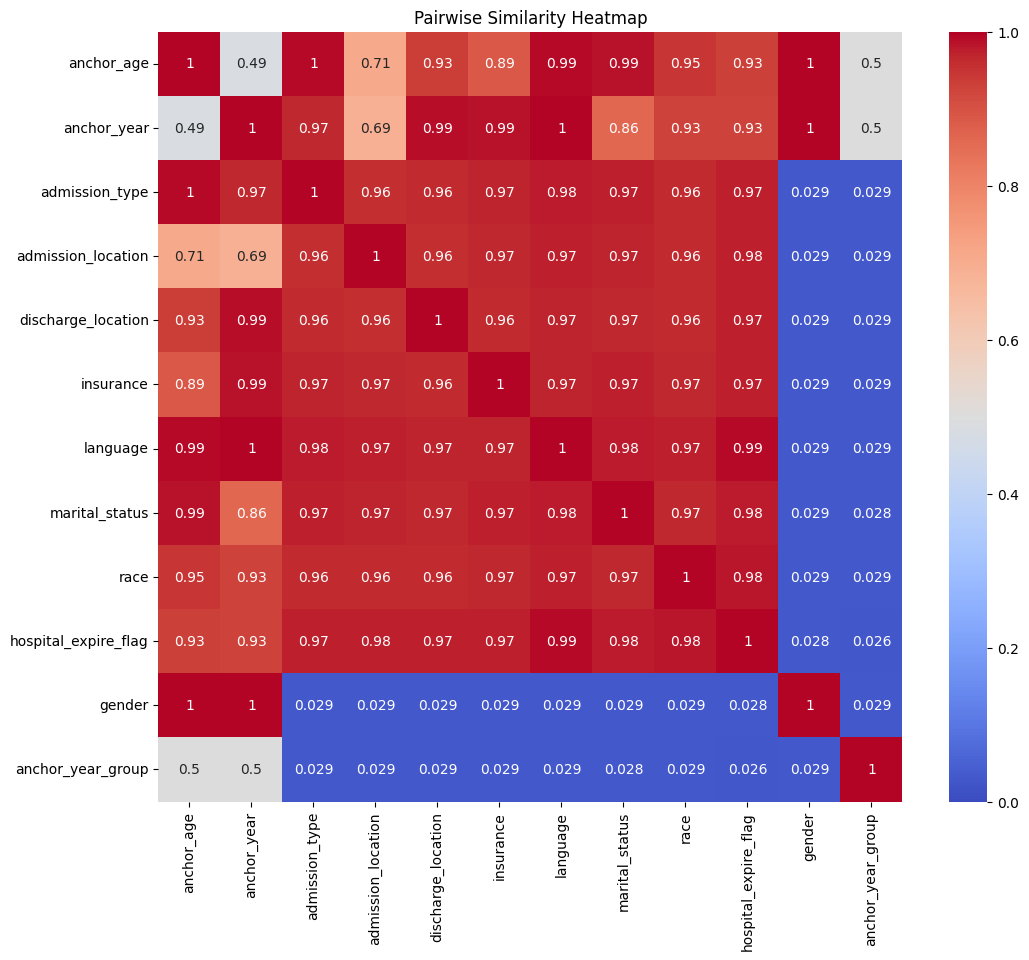

NameError: ignored

In [ ]:
import pandas as pd


real_patients_df = pd.read_csv("patients.csv")
real_admissions_df = pd.read_csv("admissions.csv")
syn_patients_df = pd.read_csv("patients_synth.csv")
syn_admissions_df = pd.read_csv("admissions_TabDDPM_default_transformer_300_1_0.csv")


real_merged_df = real_admissions_df.merge(real_patients_df, on='subject_id', how='left')
syn_merged_df = syn_admissions_df.merge(syn_patients_df, on='subject_id', how='left')


# merged_df.to_csv("merged_output.csv", index=False)


categorical_attributes = ['admission_type','admission_location', 'discharge_location','insurance', 'language', 'marital_status','race', 'hospital_expire_flag', 'gender', 'anchor_year_group']
numerical_attributes = ['anchor_age', 'anchor_year']

result_table = evaluate_pairwise_similarity(real_merged_df, syn_merged_df, numerical_attributes, categorical_attributes)
plot_heatmap(result_table)
result_table


score = ContingencySimilarity.compute(
          real_data=real_data[['gender', 'race']],
          synthetic_data=synthetic_data[['gender', 'race']]
        )
print(score)